<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract two integers that are at most two digits long.

For example, given input strings of 5 characters: ‘81+24’ or’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries.

Additionally, we want to build a model that generalizes well - if the network can extract the underlying principles behind the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries.

To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
from scipy.ndimage import rotate

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create +, - and * simulated images

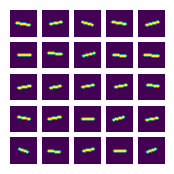

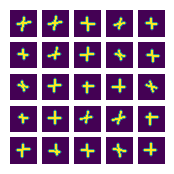

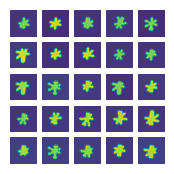

In [ ]:
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw line with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw line with randomized coordinates
        if sign == '*': # consists of 3 lines which are rotated w.r.t. each other.
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw line with randomized coordinates
            # Rotate 45 degrees to create next lines
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw line with randomized coordinates
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw line with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images(sign='-'))
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='*'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1->highest integer][+ or -][1->highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images (one per number and operation, i.e. 51+21 is the sequence of 5 images) of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28) (for negative numbers: '-xx', for positive smaller than 100: ' xx' (note the padding of ' '))

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7863

X_text: "39-31" = y_text: "8  "


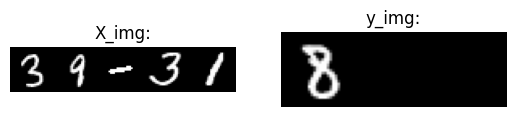

Query #3979

X_text: "19-89" = y_text: "-70"


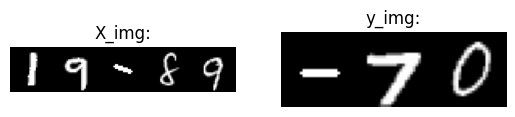

Query #892

X_text: "4+46 " = y_text: "50 "


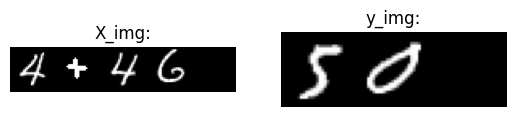

Query #7900

X_text: "39+50" = y_text: "89 "


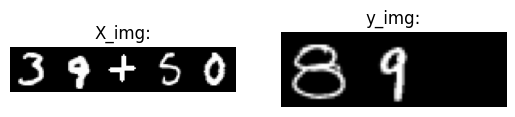

Query #3037

X_text: "15-18" = y_text: "-3 "


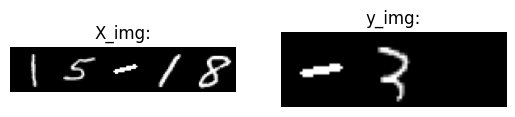

Query #4336

X_text: "21+68" = y_text: "89 "


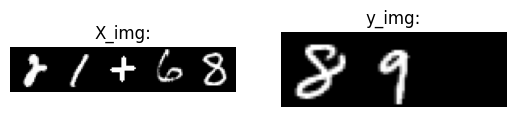

Query #602

X_text: "3+1  " = y_text: "4  "


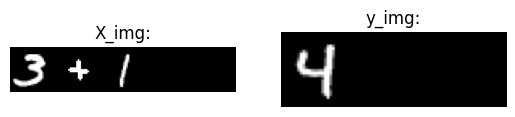

Query #8492

X_text: "42+46" = y_text: "88 "


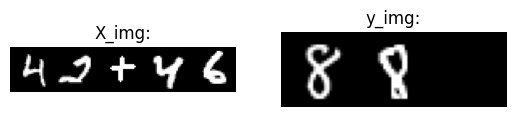

Query #8144

X_text: "40+72" = y_text: "112"


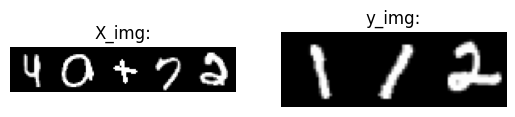

Query #284

X_text: "1+42 " = y_text: "43 "


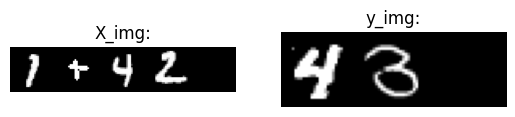

In [ ]:
# Illustrate the generated query/answer pairs

# Setup
unique_characters = '0123456789+- '         # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                        # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1   # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3                       # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

for i in range(4):

  # print(f"Encoded X_test[{i}]: \n", X_text_onehot[i])
  # print("Decoded: ",decode_labels(X_text_onehot[i]))
  print(f"Encoded y_test[{i}]: \n", y_text_onehot[i])
  print("Decoded: ",decode_labels(y_text_onehot[i]))

(20000, 5, 13) (20000, 3, 13)
Encoded y_test[0]: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Decoded:  0  
Encoded y_test[1]: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Decoded:  0  
Encoded y_test[2]: 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Decoded:  1  
Encoded y_test[3]: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Decoded:  -1 


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM (Long short-term memory)
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


#### Build model

In [ ]:
def build_text2text_model(summary: bool = False):

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if summary:
        text2text.summary()

    return text2text

#### Hyperparameter tuning

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):

def split_test(splits = np.linspace(0.1, 0.9, 9),
               data_slice=None,
               test_hyperparams: float = False,
               eval: float = False, batch_sizes = [32, 64, 128, 256],
               epochs = [20, 30, 40]):

  if test_hyperparams:
    print("Starting test for hyperparameters and splits.")
    results = []
    for i in splits:
      # Create training and test sets
      if data_slice == None:
        X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=i)
      else:
        X_train, X_test, y_train, y_test = train_test_split(X_text_onehot[:data_slice], y_text_onehot[:data_slice], train_size=i)

      # Go over hyperparameters
      for batch in batch_sizes:
        for epoch_num in epochs:
          print(f"Now testing split {i = }, batch size {batch}, epoch num {epoch_num}")
          # Initialize model
          T2T = build_text2text_model()
          # Fit model
          history = T2T.fit(X_train, y_train, batch_size=batch, validation_split=1-i, epochs=epoch_num, verbose=0, shuffle=True)

          # Get the accuracy and validation accuracy
          Train_acc = history.history['accuracy']
          Test_acc = history.history['val_accuracy']

          # Append train test acc and corresponding batch size and number of epochs
          results.append([Train_acc, Test_acc, {'batch': batch,
                                                'Epoch num': epoch_num,
                                                'split size': i}])

          # Evaluate model
          if eval:
            T2T.evaluate(X_test, y_test)

    return results

  else:
    print("Starting test for splits with default hyperparameters.")
    results = []
    for i in splits:
      print(f"Now testing split {i = }")
      # Create training and test sets
      if data_slice == None:
        X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=i)
      else:
        X_train, X_test, y_train, y_test = train_test_split(X_text_onehot[:data_slice], y_text_onehot[:data_slice], train_size=i)

      # Initialize model
      T2T = build_text2text_model()
      # Fit model
      history = T2T.fit(X_train, y_train, batch_size=256, validation_split=1-i, epochs=20, verbose=0, shuffle=True)

      # Get the accuracy and validation accuracy
      Train_acc = history.history['accuracy']
      Test_acc = history.history['val_accuracy']
      results.append([Train_acc, Test_acc])

      # Evaluate model
      if eval:
        T2T.evaluate(X_test, y_test)

    return results

#### First run of hyperparameter tuning

In [ ]:
result_default = split_test(splits = np.linspace(0.1, 0.9, 9),
                            data_slice=None, test_hyperparams=False,
                            batch_sizes = [32, 64, 128, 256],
                            epochs = [20, 30, 40])

Starting test for splits with default hyperparameters.
Now testing split i = 0.1
Now testing split i = 0.2
Now testing split i = 0.30000000000000004
Now testing split i = 0.4
Now testing split i = 0.5
Now testing split i = 0.6
Now testing split i = 0.7000000000000001
Now testing split i = 0.8
Now testing split i = 0.9


#### Make a plot of accuracy for training and testing for the default hyperparameters

In [ ]:
def multi_subplot(images, n=3, splits = np.linspace(0.1, 0.9, 9)):
    plt.figure(figsize=(6, 6))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.subplots_adjust(left=0.1, right=1.5, bottom=0.1, top=0.9, wspace=0.4, hspace=0.8)
        plt.title(f"Training and testing split {round(splits[i], 2)}", fontsize=10)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")

        # Plot training and testing accuracy
        plt.plot(np.linspace(1, len(images[i][0]), len(images[i][0])), images[i][0], label='Training', color='blue')
        plt.plot(np.linspace(1, len(images[i][0]), len(images[i][0])), images[i][1], label='Testing', color='red')
        plt.grid()

    plt.legend(loc=(1.2, 4))


    plt.show()

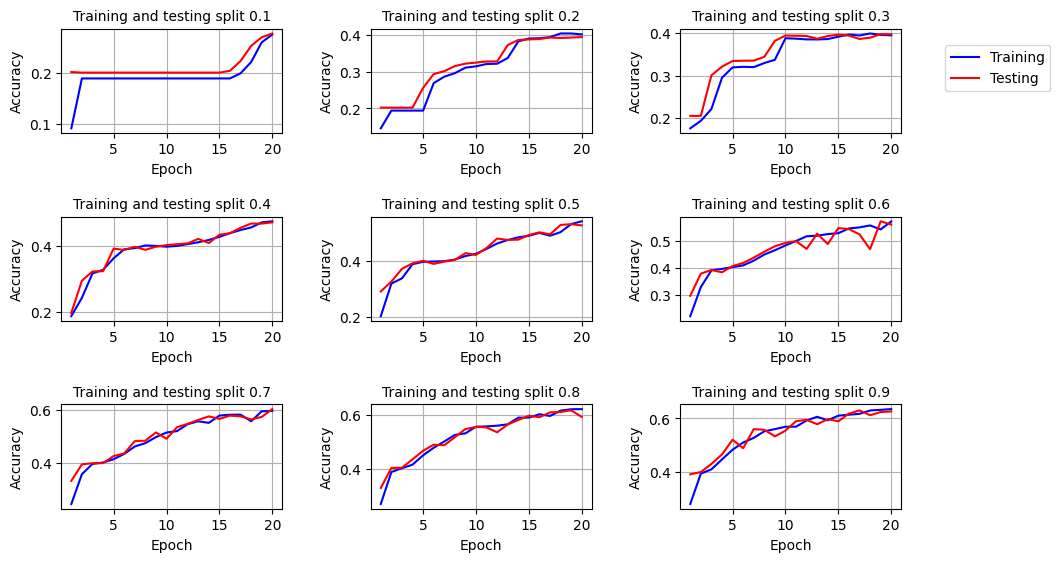

In [ ]:
multi_subplot(result_default, n=3)

#### Find the best combination of batch size, epochs and split size

Now find the best set, run with varying batch size and number of epochs. Also use the result from above, a split size that is too small will not give good accuracy. We should start with splits of 0.25, moving up in steps of 0.25, i.e. 0.25, 0.5, 0.75 and finally use 0.9.

After this, find the highest accuracies (top 9) of the simulated combinations of hyperparameters for the text2text model, and plot the curves in similar fashion as done directly in the code block above.

In [ ]:
result_hyperparam = split_test(splits = [0.25, 0.5, 0.75, 0.9],
                               data_slice=None, test_hyperparams=True,
                               batch_sizes = [32, 64, 128, 256],
                                epochs = [20, 30, 40])

Starting test for hyperparameters and splits.
Now testing split i = 0.25, batch size 32, epoch num 20
Now testing split i = 0.25, batch size 32, epoch num 30
Now testing split i = 0.25, batch size 32, epoch num 40
Now testing split i = 0.25, batch size 64, epoch num 20
Now testing split i = 0.25, batch size 64, epoch num 30
Now testing split i = 0.25, batch size 64, epoch num 40
Now testing split i = 0.25, batch size 128, epoch num 20
Now testing split i = 0.25, batch size 128, epoch num 30
Now testing split i = 0.25, batch size 128, epoch num 40
Now testing split i = 0.25, batch size 256, epoch num 20
Now testing split i = 0.25, batch size 256, epoch num 30
Now testing split i = 0.25, batch size 256, epoch num 40
Now testing split i = 0.5, batch size 32, epoch num 20
Now testing split i = 0.5, batch size 32, epoch num 30
Now testing split i = 0.5, batch size 32, epoch num 40
Now testing split i = 0.5, batch size 64, epoch num 20
Now testing split i = 0.5, batch size 64, epoch num 30
N

In [ ]:
# Initialize a list to store the top 9 elements
top_5_count = [0]
top_5_values = [0]
top_5_acc_train = [0]
# Iterate through the list
for index, sublist in enumerate(result_hyperparam):
    # print(top_9_elements)

    # Extract the first subsublist
    first_subsublist = sublist[0]

    # Calculate the last value of training accuracy
    current_value = first_subsublist[-1]
    # print(current_value)

    # Check if the current value is greater than the smallest value in the top 9 list
    if current_value > min(top_5_acc_train):

      # if top 9 is full, remove the lowest score
      if len(top_5_acc_train) == 5:
          # Find index of lowest training acc
          min_index = top_5_acc_train.index(min(top_5_acc_train))

          # Remove item from all lists
          top_5_acc_train.remove(min(top_5_acc_train))
          top_5_count.remove(top_5_count[min_index])
          top_5_values.remove(top_5_values[min_index])

      # If so, add the current element to the top 9 list
      top_5_acc_train.append(current_value)
      top_5_count.append(index)
      top_5_values.append(sublist)


# Sort the top 9 list based on the values in descending order
top_5_index = sorted(top_5_count, reverse=True)
top_5_index

[40, 38, 37, 36, 29]

In [ ]:
# Sort the list of sublists based on the values of their first elements in descending order
sorted_top_5_values = sorted(top_5_values, key=lambda x: x[0], reverse=True)

In [ ]:
for i in sorted_top_5_values:
  sublist = i[0]
  print(sublist[-1])

0.9969135522842407
0.9935596585273743
0.9839506149291992
0.992572009563446
0.9907259345054626


Best model is

In [ ]:
sorted_top_5_values[0][-1]

{'batch': 32, 'Epoch num': 40, 'split size': 0.9}

#### Check for the highest performance model which instances are labelled wrong.


1. First we have to re-run using the hyperparams to create the network.
2.   We then save the weights, followed by creating a prediction on all instances
3. Lastly, we check the which instances are labbeled incorrectly. Check for example if it is a sign difference, or how large the differences are.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=0.9)
# Initialize model
T2T = build_text2text_model()
# Fit model
history = T2T.fit(X_train, y_train, batch_size=32, validation_split=1-0.9, epochs=20, verbose=1, shuffle=True)
# Save weights
T2T.save_weights('/content/drive/MyDrive/IDL/weights_1_2_T2T.keras')

Epoch 1/20
507/507 [==============================] - 8s 8ms/step - loss: 1.7581 - accuracy: 0.3953 - val_loss: 1.4662 - val_accuracy: 0.4920
Epoch 2/20
507/507 [==============================] - 4s 9ms/step - loss: 1.3394 - accuracy: 0.5153 - val_loss: 1.2639 - val_accuracy: 0.5331
Epoch 3/20
507/507 [==============================] - 3s 6ms/step - loss: 1.1720 - accuracy: 0.5714 - val_loss: 1.1390 - val_accuracy: 0.5693
Epoch 4/20
507/507 [==============================] - 5s 9ms/step - loss: 1.0927 - accuracy: 0.5966 - val_loss: 1.0926 - val_accuracy: 0.5861
Epoch 5/20
507/507 [==============================] - 3s 7ms/step - loss: 1.0297 - accuracy: 0.6161 - val_loss: 0.9860 - val_accuracy: 0.6274
Epoch 6/20
507/507 [==============================] - 4s 8ms/step - loss: 0.9795 - accuracy: 0.6317 - val_loss: 0.9642 - val_accuracy: 0.6443
Epoch 7/20
507/507 [==============================] - 4s 8ms/step - loss: 0.9406 - accuracy: 0.6452 - val_loss: 0.9293 - val_accuracy: 0.6441
Epoch 

Save evolution of accuracy on training and test set

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

my_array = np.array(train_acc)
filename = 'train_acc_1_2.npy'
np.save('/content/drive/MyDrive/IDL'+filename, my_array)

my_array = np.array(test_acc)
filename = 'test_acc_1_2.npy'
np.save('/content/drive/MyDrive/IDL'+filename, my_array)

Plot evolution over epochs

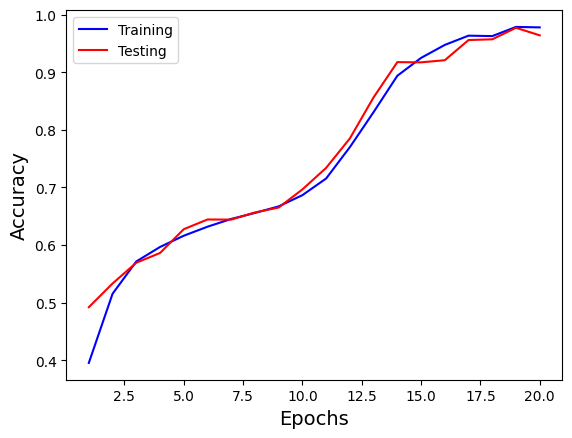

In [ ]:
train_acc = np.load('/content/drive/MyDrive/IDLtrain_acc_1_2.npy')
test_acc = np.load('/content/drive/MyDrive/IDLtest_acc_1_2.npy')

plt.plot(np.linspace(1, len(train_acc), len(train_acc)), train_acc, color='blue', label='Training')
plt.plot(np.linspace(1, len(test_acc), len(test_acc)), test_acc, color='red', label='Testing')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.show()


Predictions

In [ ]:
T2T.load_weights('/content/drive/MyDrive/IDL/weights_1_2_T2T.keras')
y_pred = T2T.predict(X_text_onehot)

625/625 [==============================] - 5s 6ms/step


In [ ]:
len(y_text)

20000

Example of extracting the prediction

In [ ]:
def decode_all(predictions):
  decoded_predicitons = np.array([])
  for prediction in predictions:
    decoded_predicitons = np.append(decoded_predicitons, decode_labels(prediction))
  return decoded_predicitons

decoded_predictions = decode_all(y_pred)

In [ ]:
decoded_predictions

array(['0  ', '09 ', '1  ', ..., '2  ', '198', '0  '], dtype='<U32')

In [ ]:
y_text

array(['0  ', '0  ', '1  ', ..., '1  ', '198', '0  '], dtype='<U3')

Check the number of correctly classified instances

In [ ]:
def check_classification(y_pred, y_true):
  correct = 0
  incorrect = 0
  incorrect_dict = {'y_pred': [],
                    'y_true': []}
  incorrect_indices = []
  for index, value in enumerate(y_true):
    if value == y_pred[index]:
      correct +=1
    else:
      incorrect +=1
      incorrect_indices.append(index)
      incorrect_dict['y_pred'].append(y_pred[index])
      incorrect_dict['y_true'].append(value)


  return correct, incorrect, incorrect_indices, incorrect_dict

In [ ]:
correct_num, incorrect_num, incorrect_indices, diction = check_classification(decoded_predictions, y_text)

Visualize the incorrectly labbeled instances. In order to do so, we need to convert our strings to integers. Note that due to white spacing we must first subtract any white spacing, before converting to integers. Furthermore, we should note exceptions such as '- ' which is basically just a black, we should completely remove these, but do count them up. These are of course completely wrong as no number is present.

In [ ]:
def process_strings(input_list):
    cleaned_list = []
    invalid_count = 0

    for item in input_list:
        # Remove white spaces and leading/trailing dashes
        cleaned_item = item.replace(" ", "")
        # Replace double white spaces with a single space
        cleaned_item = ' '.join(cleaned_item.split())

        try:
            # Convert the cleaned item to an integer
            cleaned_item_int = int(cleaned_item)
            cleaned_list.append(cleaned_item_int)
        except ValueError:
            # Handle the case where conversion to integer is not possible

            # If such a case arises, append a value of 999
            cleaned_list.append(999)
            invalid_count += 1

    return cleaned_list, invalid_count

# Example usage:
input_strings = [" 123 ", "45", "- 67", "89- ", "  -  10 ", "abc", "12  34"]
cleaned_numbers, invalid_count = process_strings(input_strings)

print("Cleaned Numbers:", cleaned_numbers)
print("Invalid Count:", invalid_count)


Cleaned Numbers: [123, 45, -67, 999, -10, 999, 1234]
Invalid Count: 2


In [ ]:
# Apply to wrong instances
cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(decoded_predictions[incorrect_indices])
cleaned_true, invalid_true = process_strings(y_text[incorrect_indices])

# Check for invalid cases
print(invalid_count_wrong_classified, invalid_true)


15 0


Visualize the wrongly labelled instances

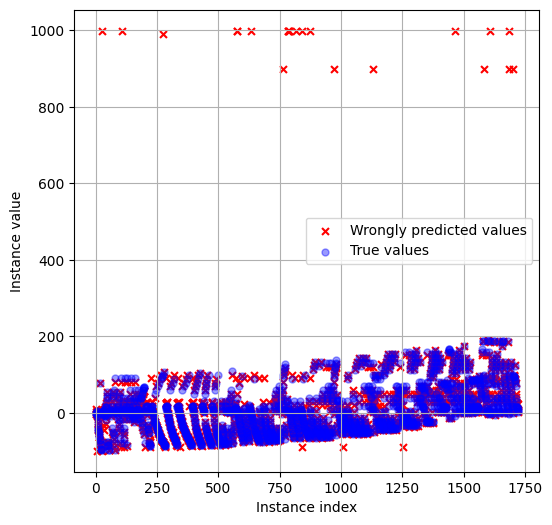

In [ ]:
plt.figure(figsize=(6, 6))
artists = {}
# Plot instances that were wrongly labeled
for count, value in enumerate(cleaned_wrong_classified):
    artist = plt.scatter(count, value, color='red', marker='x', s=25)
    artists['Wrongly predicted values'] = artist

# Plot true values of the wrongly classified instances
for count, value in enumerate(cleaned_true):
    all_instances_artist = plt.scatter(count, value, color='blue', marker='o', s=25, alpha=0.4)
    artists['True values'] = all_instances_artist

# Customize the plot
plt.xlabel('Instance index')
plt.ylabel('Instance value')
plt.grid()
# Create a legend with unique labels
plt.legend(artists.values(), artists.keys())
plt.show()



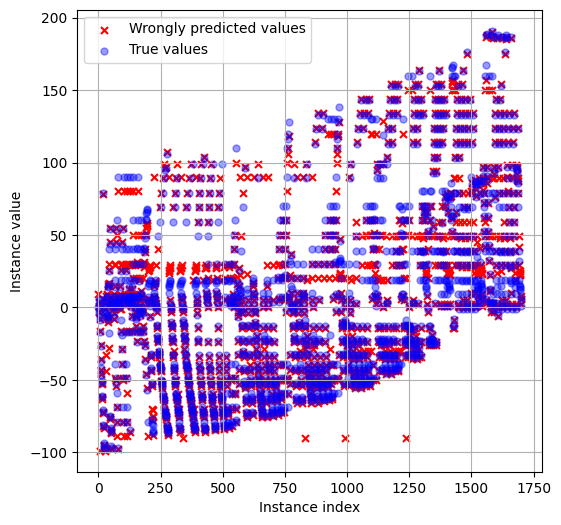

In [ ]:
# Create the same figure but only plot values below 200

cleaned_wrong_classified = np.array(cleaned_wrong_classified)
cleaned_true = np.array(cleaned_true)

mask = cleaned_wrong_classified < 200

# Plot
plt.figure(figsize=(6, 6))
artists = {}
# Plot instances that were wrongly labeled
for count, value in enumerate(cleaned_wrong_classified[mask]):
    artist = plt.scatter(count, value, color='red', marker='x', s=25)
    artists['Wrongly predicted values'] = artist

# Plot true values of the wrongly classified instances
for count, value in enumerate(cleaned_true[mask]):
    all_instances_artist = plt.scatter(count, value, color='blue', marker='o', s=25, alpha=0.4)
    artists['True values'] = all_instances_artist

# Customize the plot
plt.xlabel('Instance index')
plt.ylabel('Instance value')
plt.grid()
# Create a legend with unique labels
plt.legend(artists.values(), artists.keys())
plt.show()


Make a sub plot that plots in batches of 250 to obtain better visability.

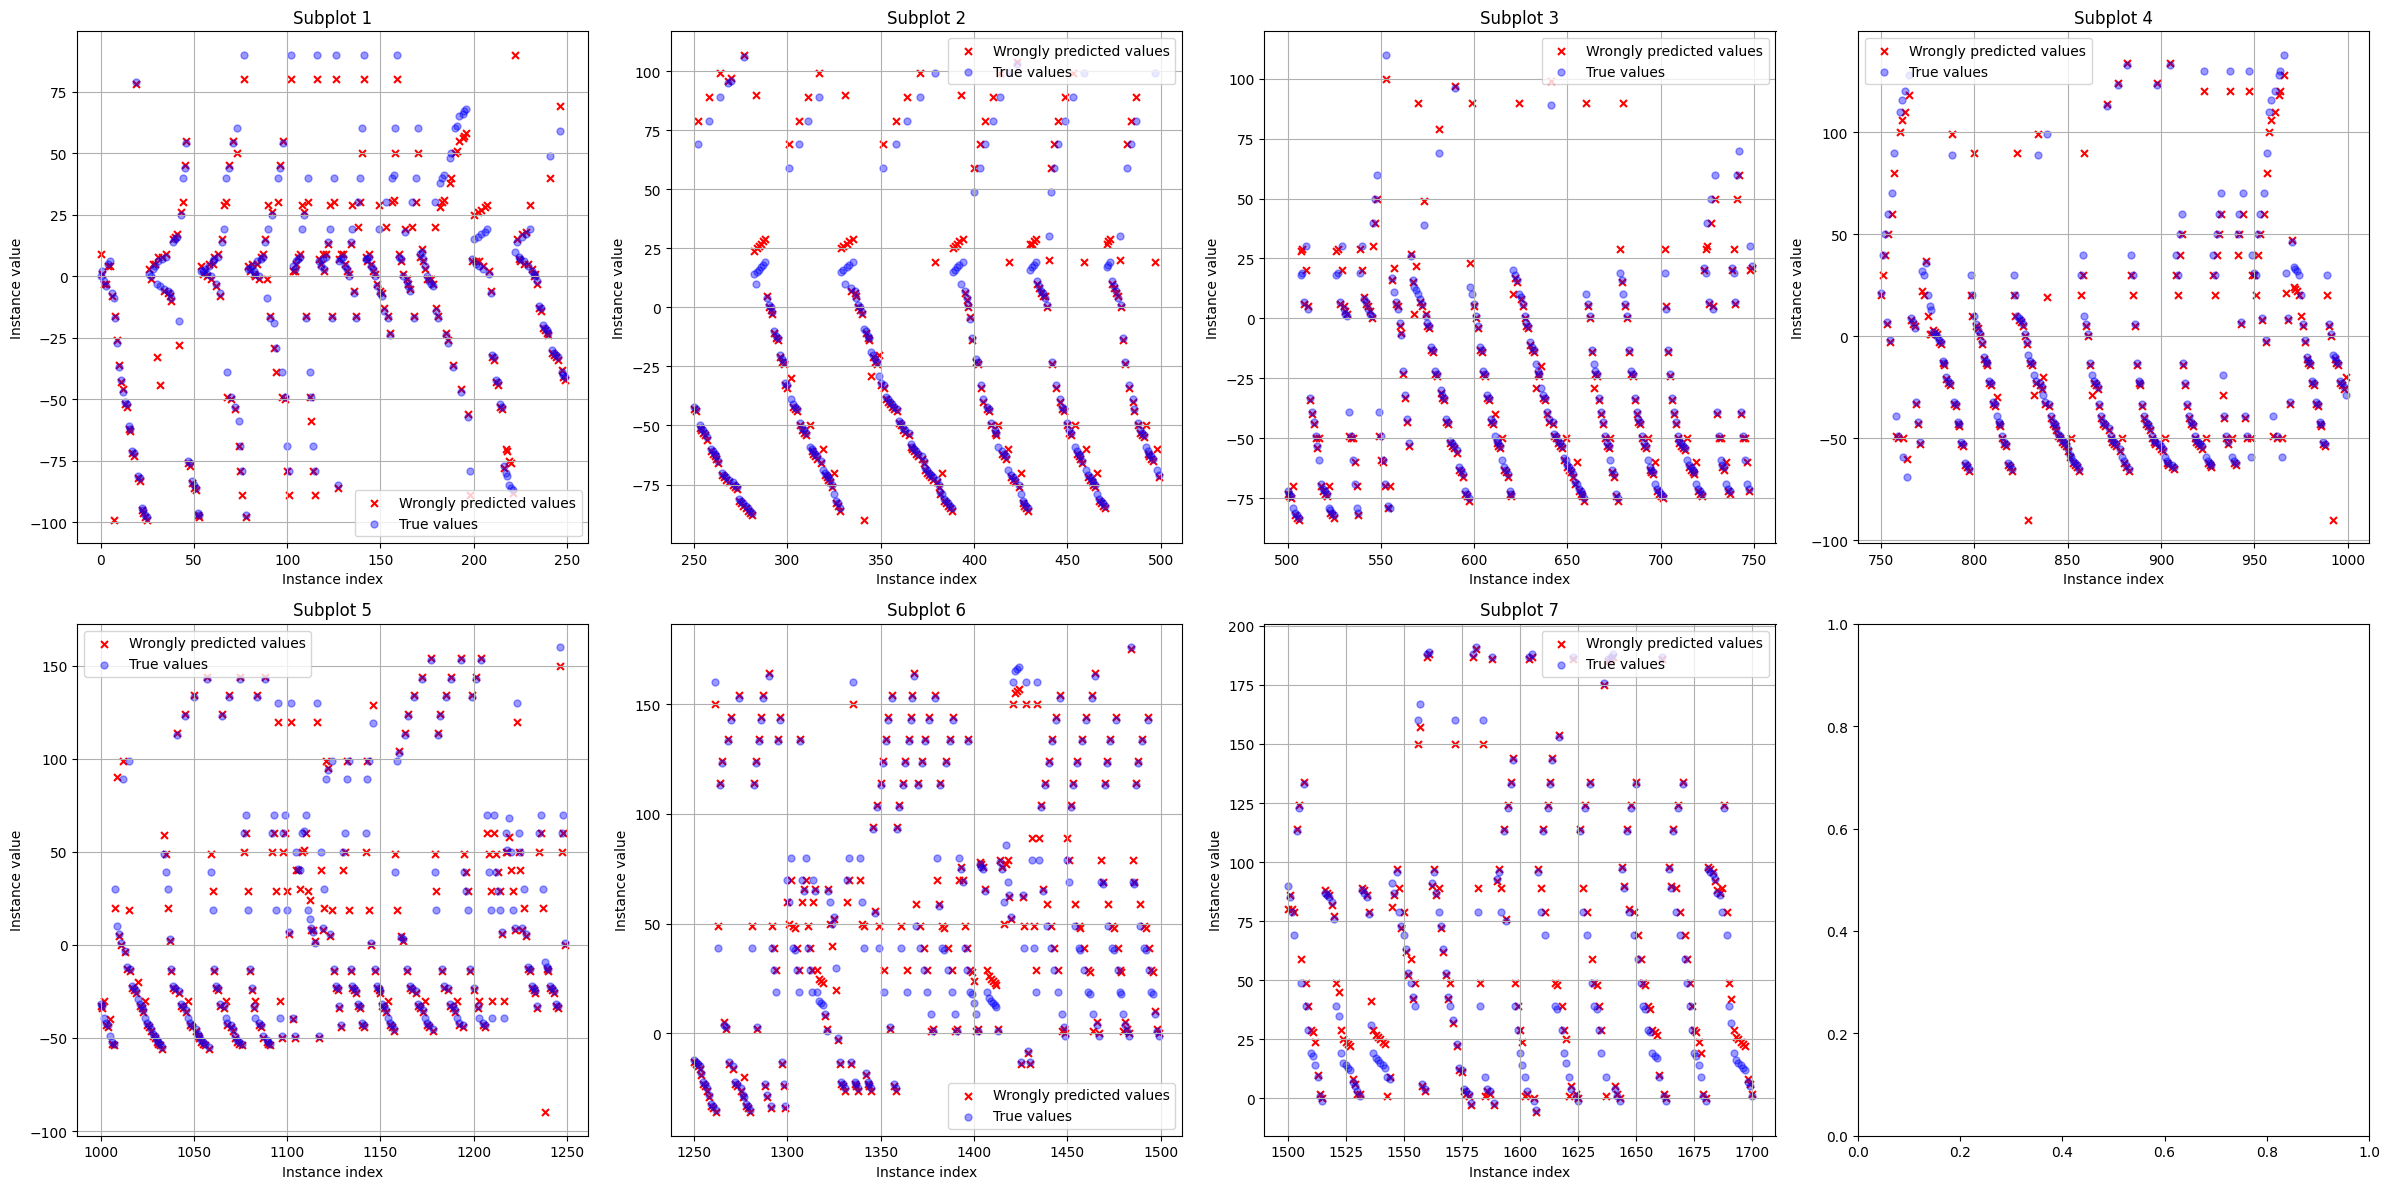

In [ ]:
# Set the batch size
batch_size = 250

# Get the total number of instances
total_instances = len(cleaned_wrong_classified[mask])

# Calculate the number of subplots needed
num_subplots = int(np.ceil(total_instances / batch_size))

# Calculate the number of rows and columns for the subplot grid
num_rows = int(np.sqrt(num_subplots))
num_cols = int(np.ceil(num_subplots / num_rows))

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 12))

# Flatten the axs array if it's a multi-dimensional array
axs = axs.flatten()

# Plot instances in batches of 250
for i in range(num_subplots):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, total_instances)

    # Use the current subplot
    ax = axs[i]

    # Plot instances that were wrongly labeled
    ax.scatter(range(start_index, end_index), cleaned_wrong_classified[mask][start_index:end_index],
               color='red', marker='x', label='Wrongly predicted values', s=25)

    # Plot true values of the wrongly classified instances
    ax.scatter(range(start_index, end_index), cleaned_true[mask][start_index:end_index],
               color='blue', marker='o', label='True values', s=25, alpha=0.4)

    # Customize the subplot
    ax.set_xlabel('Instance index')
    ax.set_ylabel('Instance value')
    ax.set_title(f'Subplot {i+1}')
    ax.grid()

    # Create a legend with unique labels
    ax.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the grid of subplots
plt.show()


Make seperate plots for positive and negative true labels

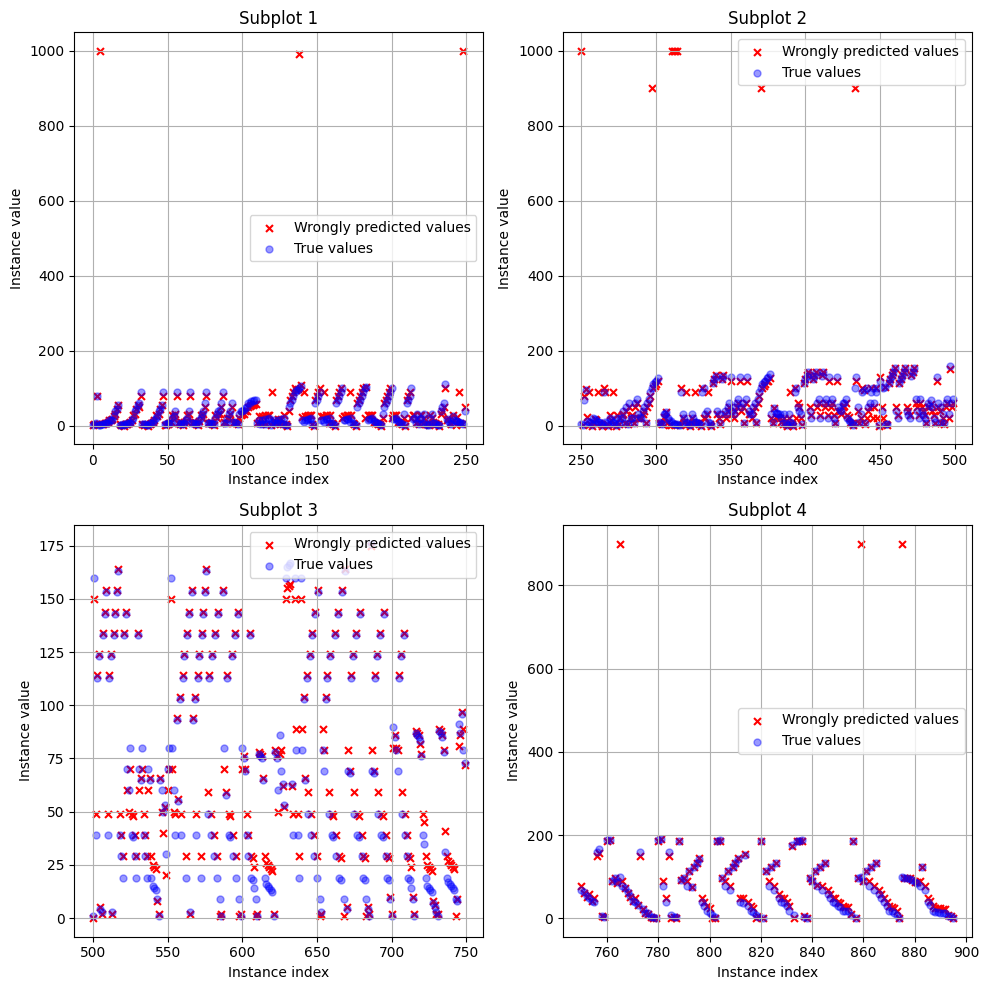

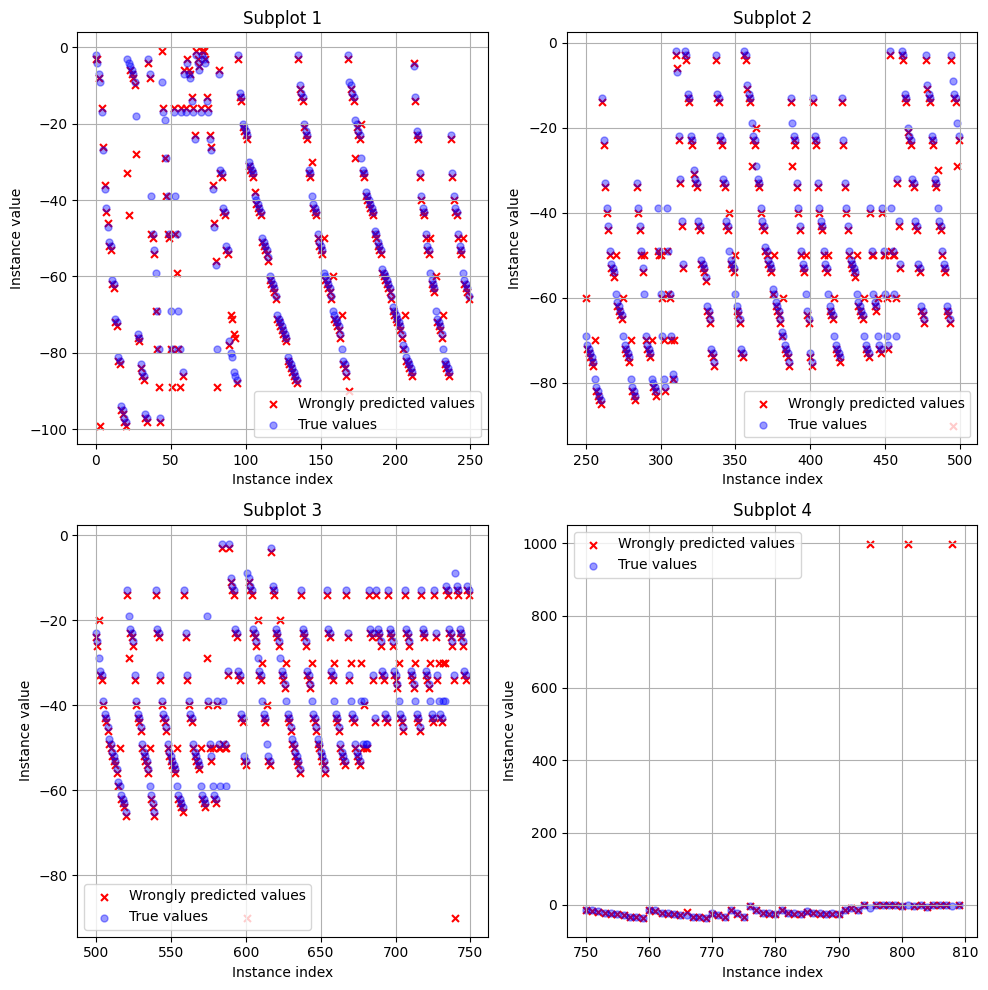

In [ ]:
# Positive
def make_subplot_figure(mask= cleaned_true > 0 , batch_size=250):
  total_instances = len(cleaned_wrong_classified[mask])
  num_subplots = int(np.ceil(total_instances / batch_size))
  num_rows = int(np.sqrt(num_subplots))
  num_cols = int(np.ceil(num_subplots / num_rows))
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  axs = axs.flatten()
  for i in range(num_subplots):
      start_index = i * batch_size
      end_index = min((i + 1) * batch_size, total_instances)
      ax = axs[i]
      ax.scatter(range(start_index, end_index), cleaned_wrong_classified[mask][start_index:end_index],
                color='red', marker='x', label='Wrongly predicted values', s=25)
      ax.scatter(range(start_index, end_index), cleaned_true[mask][start_index:end_index],
                color='blue', marker='o', label='True values', s=25, alpha=0.4)
      ax.set_xlabel('Instance index')
      ax.set_ylabel('Instance value')
      ax.set_title(f'Subplot {i+1}')
      ax.grid()

      ax.legend()

  plt.tight_layout()
  plt.show()

make_subplot_figure()

# Negative
make_subplot_figure(mask = cleaned_true < 0)


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
## Your code








---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code










---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #4402

X_text: "44*2 " = y_text: "88   "


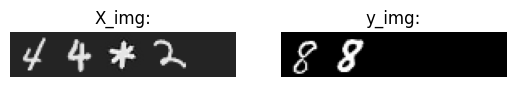

Query #4265

X_text: "42*65" = y_text: "2730 "


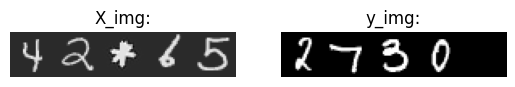

Query #2300

X_text: "23*0 " = y_text: "0    "


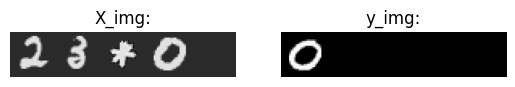

Query #2489

X_text: "24*89" = y_text: "2136 "


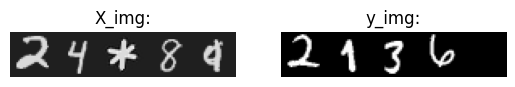

Query #2376

X_text: "23*76" = y_text: "1748 "


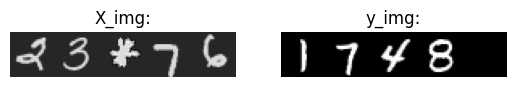

Query #9125

X_text: "91*25" = y_text: "2275 "


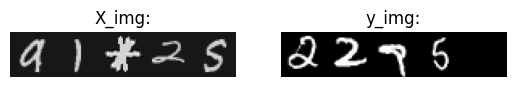

Query #2327

X_text: "23*27" = y_text: "621  "


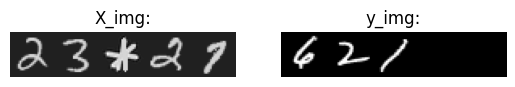

Query #7336

X_text: "73*36" = y_text: "2628 "


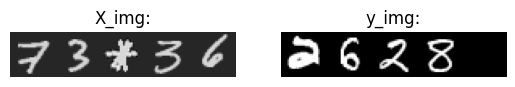

Query #6128

X_text: "61*28" = y_text: "1708 "


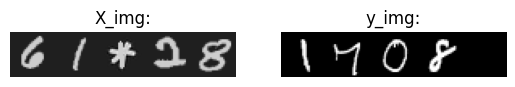

Query #8144

X_text: "81*44" = y_text: "3564 "


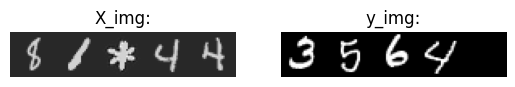

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [ ]:
## Your code










